In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


In [2]:
fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
x_columns = ['v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos',]

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_cat']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_cat']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_cat']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(44751, 11)
(44751,)


In [3]:
valid_y

array([2, 2, 2, ..., 1, 1, 1], dtype=int64)

In [4]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled = scaler.fit_transform(test_x)

In [5]:
print(np.max(train_x_scaled), np.min(train_x_scaled))

5.062937084595556 -5.515961514148879


In [6]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[11,]),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [7]:
model.layers

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 11)                0         
                                                                 
 dense (Dense)               (None, 9)                 108       
                                                                 
 dense_1 (Dense)             (None, 6)                 60        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
Total params: 189
Trainable params: 189
Non-trainable params: 0
_________________________________________________________________


In [9]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [10]:
# H:/github/python/seafog/
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
    ]
history = model.fit(train_x_scaled, train_y, epochs=100,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.9382 - accuracy: 0.5820 - val_loss: 0.7941 - val_accuracy: 0.6082
Epoch 2/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.7345 - accuracy: 0.6293 - val_loss: 0.6952 - val_accuracy: 0.6481
Epoch 3/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.6626 - accuracy: 0.6773 - val_loss: 0.6427 - val_accuracy: 0.6924
Epoch 4/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.6224 - accuracy: 0.7059 - val_loss: 0.6141 - val_accuracy: 0.7077
Epoch 5/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.6013 - accuracy: 0.7148 - val_loss: 0.5994 - val_accuracy: 0.7114
Epoch 6/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.5897 - accuracy: 0.7184 - val_loss: 0.5912 - val_accuracy: 0.7152
Epoch 7/50
1399/1399 [==============================] - 2s 1ms/step - loss: 0.5827 - accuracy: 0.7212 - val_loss: 0.5857 - val_accuracy:

In [11]:
type(history)

keras.callbacks.History

In [12]:
history.history

{'loss': [0.9381838440895081,
  0.7344799041748047,
  0.6626395583152771,
  0.6224440932273865,
  0.6012665629386902,
  0.5897480249404907,
  0.5826829671859741,
  0.5778592228889465,
  0.5741618871688843,
  0.5711502432823181,
  0.5685144066810608,
  0.5661860704421997,
  0.5641008019447327,
  0.5621850490570068,
  0.5604530572891235,
  0.5588465929031372,
  0.5572978854179382,
  0.5558663606643677,
  0.5544814467430115,
  0.5530815124511719,
  0.5517003536224365,
  0.5504615306854248,
  0.549138605594635,
  0.5479077696800232,
  0.5467715859413147,
  0.5456334352493286,
  0.5445889234542847,
  0.5435330867767334,
  0.5426521301269531,
  0.541702926158905,
  0.5409215092658997,
  0.5401182770729065,
  0.5393742322921753,
  0.5386379957199097,
  0.5379133820533752,
  0.5373148918151855,
  0.5366363525390625,
  0.5359809398651123,
  0.5353657603263855,
  0.5347800254821777,
  0.5341824293136597,
  0.5336117744445801,
  0.5330126881599426,
  0.5324660539627075,
  0.5318775773048401,
  0.

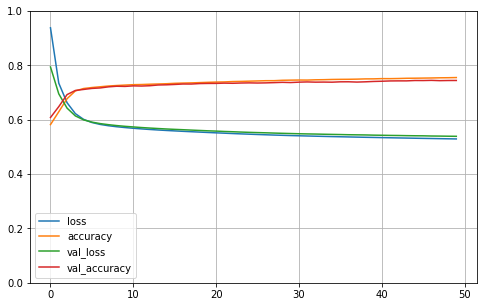

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [14]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[0.555449903011322, 0.74073326587677]

In [15]:
predictions = model(test_x_scaled).numpy()
predictions

array([[2.4078640e-03, 6.4952868e-01, 3.4806356e-01],
       [1.2383425e-04, 8.9175500e-02, 9.1070068e-01],
       [5.3073990e-04, 3.4899646e-01, 6.5047282e-01],
       ...,
       [1.7594192e-03, 2.1497180e-01, 7.8326875e-01],
       [2.3320245e-03, 1.5212163e-01, 8.4554636e-01],
       [3.8411923e-02, 6.0971349e-01, 3.5187462e-01]], dtype=float32)

In [17]:
p_test = tf.nn.softmax(predictions).numpy()



In [19]:
p_test[:,0]

array([0.23132351, 0.21839339, 0.23082308, ..., 0.22612081, 0.22294484,
       0.24162032], dtype=float32)

In [20]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

<AxesSubplot:>

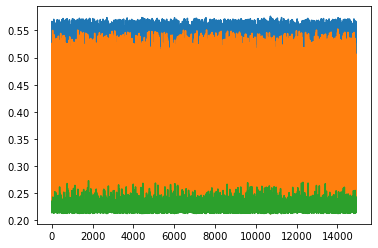

In [31]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [42]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

               visi      v100      v10m      u100      u10m       t2mm  \
1475   20431.679688 -4.196533 -3.690186 -8.414566 -7.320053  18.827423   
9178   26983.423828 -4.011703 -4.113556 -7.659546 -6.213837  28.906128   
6034    2959.770264 -2.936829 -2.561752 -9.737274 -8.392441  26.130096   
5946   14644.379883  0.843018  0.139984 -7.069595 -5.046249  22.987518   
13080  27919.111328  3.941437  2.233749 -1.736786 -2.094391  31.063965   

            t2md       sstk         actual_time           init_time  ...  \
1475   15.851593  20.140778 2022-01-02 06:00:00 2021-12-28 00:00:00  ...   
9178   26.968628  30.554840 2021-07-05 06:00:00 2021-06-30 00:00:00  ...   
6034   22.008514  28.215973 2019-10-17 12:00:00 2019-10-10 12:00:00  ...   
5946   21.988525  22.522125 2018-12-21 12:00:00 2018-12-14 12:00:00  ...   
13080  24.990570  28.686920 2021-05-11 06:00:00 2021-05-07 12:00:00  ...   

       year_cos       day_sin       day_cos  station_vis  station_rain1  \
1475   0.999408  1.0000

In [34]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 

14919